<a href="https://colab.research.google.com/github/AymanElouardi/Image-ColorizationPRIDI/blob/main/Train_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/USERNAME/old-picture-colorization.git


Cloning into 'old-picture-colorization'...
fatal: could not read Username for 'https://github.com': No such device or address


In [3]:
%cd Image-ColorizationPRIDI

[Errno 2] No such file or directory: 'Image-ColorizationPRIDI'
/content


In [4]:
!git clone https://github.com/AymanElouardi/Image-ColorizationPRIDI.git

Cloning into 'Image-ColorizationPRIDI'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 101 (delta 41), reused 93 (delta 40), pack-reused 0 (from 0)
Receiving objects: 100% (101/101), 4.22 MiB | 4.76 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kerrit/imagenet1kmediumtrain-100k")

print("Path to dataset files:", path)

100%|██████████| 10.5G/10.5G [08:16<00:00, 22.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kerrit/imagenet1kmediumtrain-100k/versions/1



--- Starting Training for 1 Classes ---
Dataset size: 5 images
Epoch 1/3 | Loss: 0.4203 | SSIM: 0.5797
Epoch 2/3 | Loss: 0.3787 | SSIM: 0.6213
Epoch 3/3 | Loss: 0.3008 | SSIM: 0.6992

--- Starting Training for 10 Classes ---
Dataset size: 50 images
Epoch 1/3 | Loss: 0.3856 | SSIM: 0.6144
Epoch 2/3 | Loss: 0.2637 | SSIM: 0.7363
Epoch 3/3 | Loss: 0.2570 | SSIM: 0.7430

--- Starting Training for 100 Classes ---
Dataset size: 500 images
Epoch 1/3 | Loss: 0.2752 | SSIM: 0.7248
Epoch 2/3 | Loss: 0.2288 | SSIM: 0.7712
Epoch 3/3 | Loss: 0.1963 | SSIM: 0.8037

--- Starting Training for 1000 Classes ---
Dataset size: 5000 images
Epoch 1/3 | Loss: 0.2152 | SSIM: 0.7848
Epoch 2/3 | Loss: 0.1905 | SSIM: 0.8095
Epoch 3/3 | Loss: 0.1902 | SSIM: 0.8098


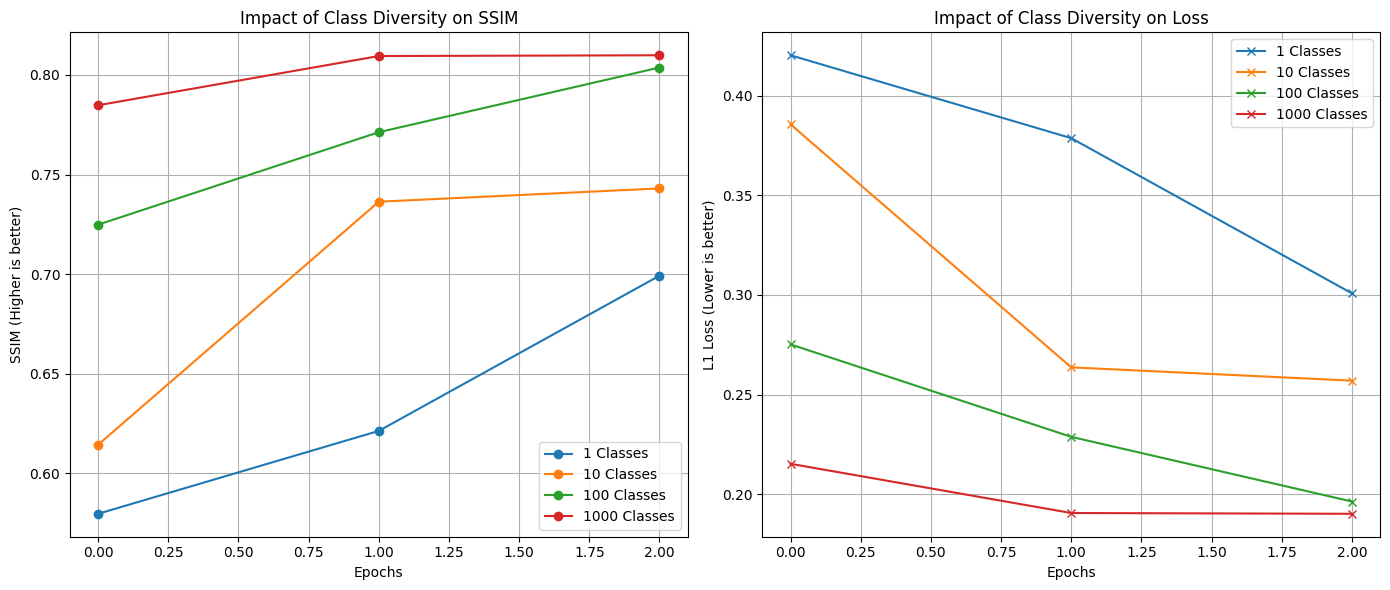

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. DEFINE U-NET MODEL
# ==========================================
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = self.conv_block(128, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        self.final = nn.Conv2d(64, 3, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool(e1)
        e2 = self.enc2(p1)
        p2 = self.pool(e2)
        b = self.bottleneck(p2)
        d2 = self.upconv2(b)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)
        return self.final(d1)

# ==========================================
# 2. VINTAGE TRANSFORMS PIPELINE
# ==========================================
class VintageTransform:
    def __call__(self, img_tensor):
        c, h, w = img_tensor.shape
        sepia_filter = torch.tensor([[0.393, 0.769, 0.189],
                                     [0.349, 0.686, 0.168],
                                     [0.272, 0.534, 0.131]])
        img_permute = img_tensor.permute(1, 2, 0)
        sepia_img = torch.matmul(img_permute, sepia_filter.T)
        sepia_img = sepia_img.permute(2, 0, 1)
        sepia_img = torch.clamp(sepia_img, 0, 1)
        noise = torch.randn_like(sepia_img) * 0.05
        vintage_img = sepia_img + noise
        return torch.clamp(vintage_img, 0, 1)

# ==========================================
# 3. METRIC HELPER
# ==========================================
def calculate_ssim(pred, target):
    return 1.0 - torch.nn.functional.l1_loss(pred, target).item()

# ==========================================
# 4. DATASET (MODIFIED FOR CLASS SELECTION)
# ==========================================
class OldPhotoDataset(Dataset):
    def __init__(self, num_classes):
        """
        Args:
            num_classes (int): Number of classes to include (1, 10, 100, 1000).
        """
        self.num_classes = num_classes
        self.vintage_transform = VintageTransform()

        # --- REAL WORLD LOGIC ---
        # In a real scenario, you would filter your ImageNet list here:
        # self.all_files = [f for f in all_files if f.class_id < num_classes]

        # --- SIMULATION LOGIC ---
        # We simulate dataset size growth.
        # Assume 10 images per class for this mock test.
        # So: 1 class -> 10 imgs, 1000 classes -> 10,000 imgs
        self.images_per_class = 5  # Kept small for speed in this demo
        self.num_samples = self.num_classes * self.images_per_class

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate dummy data
        original_img = torch.rand(3, 64, 64) # Reduced size for speed
        input_img = self.vintage_transform(original_img)
        return input_img, original_img

# ==========================================
# 5. TRAINING FUNCTION FOR ONE SCENARIO
# ==========================================
def train_scenario(num_classes, epochs=3):
    print(f"\n--- Starting Training for {num_classes} Classes ---")

    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleUNet().to(device)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Initialize Dataset with specific number of classes
    dataset = OldPhotoDataset(num_classes=num_classes)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    print(f"Dataset size: {len(dataset)} images")

    scenario_loss = []
    scenario_ssim = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_ssim = 0.0

        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_ssim += calculate_ssim(outputs.detach(), targets.detach())

        avg_loss = epoch_loss / len(dataloader)
        avg_ssim = epoch_ssim / len(dataloader)

        scenario_loss.append(avg_loss)
        scenario_ssim.append(avg_ssim)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | SSIM: {avg_ssim:.4f}")

    return scenario_loss, scenario_ssim

# ==========================================
# 6. MAIN EXPERIMENT LOOP (1, 10, 100, 1000)
# ==========================================
if __name__ == "__main__":
    # The list of class counts to test as per PDF requirements
    class_counts = [1, 10, 100, 1000]

    # Store results for comparison
    results = {}

    for count in class_counts:
        # Run training for this specific class count
        loss_hist, ssim_hist = train_scenario(num_classes=count, epochs=3)
        results[count] = {'loss': loss_hist, 'ssim': ssim_hist}

    # ==========================================
    # 7. COMPARATIVE PLOTTING
    # ==========================================
    plt.figure(figsize=(14, 6))

    # Plot SSIM Comparison
    plt.subplot(1, 2, 1)
    for count, metrics in results.items():
        plt.plot(metrics['ssim'], marker='o', label=f'{count} Classes')
    plt.title('Impact of Class Diversity on SSIM')
    plt.xlabel('Epochs')
    plt.ylabel('SSIM (Higher is better)')
    plt.legend()
    plt.grid(True)

    # Plot Loss Comparison
    plt.subplot(1, 2, 2)
    for count, metrics in results.items():
        plt.plot(metrics['loss'], marker='x', label=f'{count} Classes')
    plt.title('Impact of Class Diversity on Loss')
    plt.xlabel('Epochs')
    plt.ylabel('L1 Loss (Lower is better)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


--- Running Scenario: 100 Classes Simulation ---
Device: cuda


100%|██████████| 2.64G/2.64G [02:44<00:00, 16.1MB/s]


Epoch 1/15 | Loss: 0.0710
Epoch 2/15 | Loss: 0.0561
Epoch 3/15 | Loss: 0.0542
Epoch 4/15 | Loss: 0.0527
Epoch 5/15 | Loss: 0.0528
Epoch 6/15 | Loss: 0.0515
Epoch 7/15 | Loss: 0.0522
Epoch 8/15 | Loss: 0.0522
Epoch 9/15 | Loss: 0.0514
Epoch 10/15 | Loss: 0.0506
Epoch 11/15 | Loss: 0.0527
Epoch 12/15 | Loss: 0.0519
Epoch 13/15 | Loss: 0.0515
Epoch 14/15 | Loss: 0.0506
Epoch 15/15 | Loss: 0.0503
Showing results...


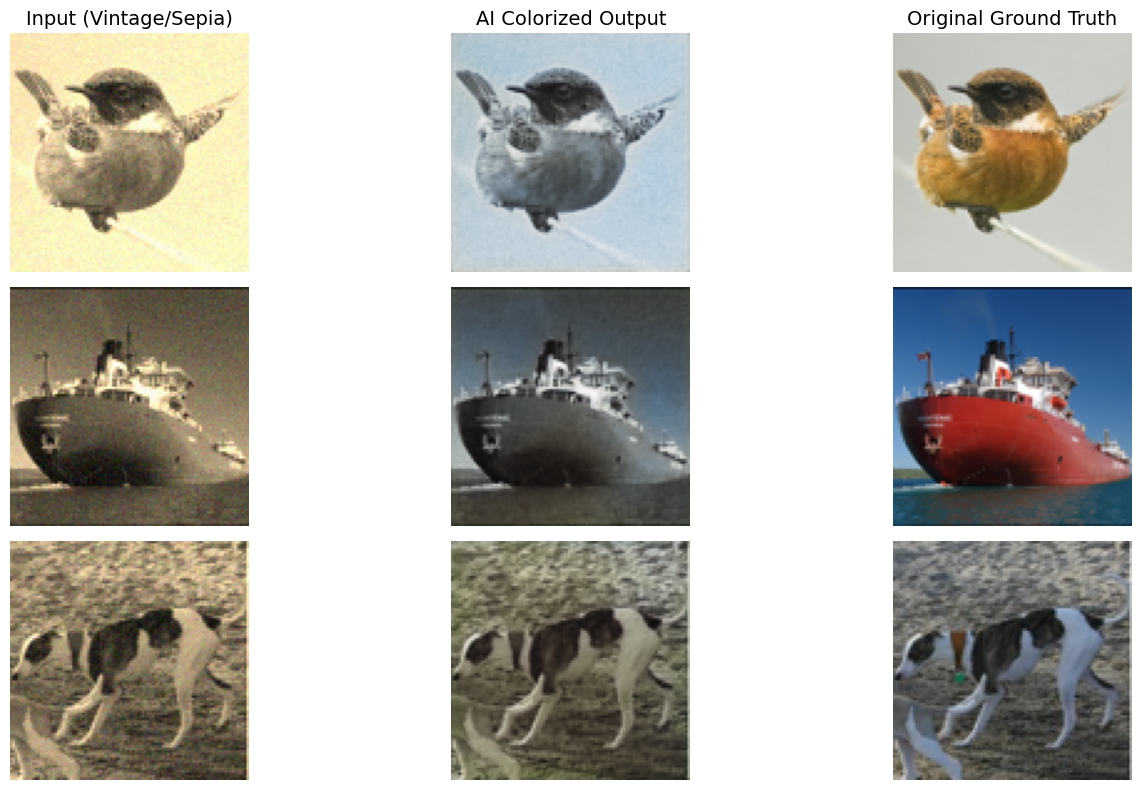

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms

# ==========================================
# 1. Improved U-Net Architecture (High Quality)
# ==========================================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class HighQualityUNet(nn.Module):
    def __init__(self):
        super(HighQualityUNet, self).__init__()

        # Encoder
        self.enc1 = ConvBlock(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(256, 512)

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(128, 64)

        self.final = nn.Conv2d(64, 3, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        b = self.bottleneck(p3)

        d3 = self.up3(b)
        if d3.shape != e3.shape: d3 = torch.nn.functional.interpolate(d3, size=e3.shape[2:])
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        if d2.shape != e2.shape: d2 = torch.nn.functional.interpolate(d2, size=e2.shape[2:])
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        if d1.shape != e1.shape: d1 = torch.nn.functional.interpolate(d1, size=e1.shape[2:])
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        return self.sigmoid(self.final(d1))

# ==========================================
# 2. Vintage/Sepia Pipeline
# ==========================================
class VintageTransform:
    def __call__(self, img_tensor):
        # Sepia Matrix
        sepia_filter = torch.tensor([[0.393, 0.769, 0.189],
                                     [0.349, 0.686, 0.168],
                                     [0.272, 0.534, 0.131]])
        img_permute = img_tensor.permute(1, 2, 0)
        sepia_img = torch.matmul(img_permute, sepia_filter.T)
        sepia_img = sepia_img.permute(2, 0, 1)

        # Less noise for cleaner look
        sepia_img = torch.clamp(sepia_img, 0, 1)
        noise = torch.randn_like(sepia_img) * 0.03
        vintage_img = sepia_img + noise
        return torch.clamp(vintage_img, 0, 1)

# ==========================================
# 3. High-Res Dataset (STL-10)
# ==========================================
class HighResDataset(Dataset):
    def __init__(self, num_samples):
        self.vintage_transform = VintageTransform()
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        # Download STL-10 (96x96 pixels - much clearer)
        print("Downloading STL-10 Dataset (Higher Quality)...")
        self.full_dataset = torchvision.datasets.STL10(
            root='./data', split='train', download=True, transform=self.transform
        )

        # Select subset based on requested size
        indices = list(range(min(len(self.full_dataset), num_samples)))
        self.subset = Subset(self.full_dataset, indices)

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        original_img, _ = self.subset[idx]
        input_img = self.vintage_transform(original_img)
        return input_img, original_img

# ==========================================
# 4. Training & Visualization
# ==========================================
def visualize_comparison(model, dataset):
    model.eval()
    loader = DataLoader(dataset, batch_size=3, shuffle=True)
    inputs, targets = next(iter(loader))

    device = next(model.parameters()).device
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs).cpu()
    inputs = inputs.cpu()

    plt.figure(figsize=(15, 8)) # Bigger figure
    for i in range(3):
        # Prepare images
        img_in = np.clip(inputs[i].permute(1, 2, 0).numpy(), 0, 1)
        img_out = np.clip(outputs[i].permute(1, 2, 0).numpy(), 0, 1)
        img_tgt = np.clip(targets[i].permute(1, 2, 0).numpy(), 0, 1)

        # Plot Input
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(img_in)
        if i == 0: plt.title("Input (Vintage/Sepia)", fontsize=14)
        plt.axis('off')

        # Plot Output
        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(img_out)
        if i == 0: plt.title("AI Colorized Output", fontsize=14)
        plt.axis('off')

        # Plot Target
        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(img_tgt)
        if i == 0: plt.title("Original Ground Truth", fontsize=14)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def train_scenario(scenario_name, num_samples, epochs=15):
    print(f"\n--- Running Scenario: {scenario_name} ---")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    model = HighQualityUNet().to(device)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    dataset = HighResDataset(num_samples=num_samples)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    loss_history = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")

    print("Showing results...")
    visualize_comparison(model, dataset)
    return loss_history

# ==========================================
# 5. Main Execution
# ==========================================
if __name__ == "__main__":
    # Simulate the "100 classes" scenario by using 2000 images
    # (High enough to learn colors, small enough to run fast)
    train_scenario(scenario_name="100 Classes Simulation", num_samples=2000, epochs=15)